## Step 1: Import the data, from two subreddits ##
## Step 2: Train test split and fit our model to the train, score on split ##

1. Function all_together takes two subreddits, scrapes the top thousand posts from each of them, saves it to a csv. Combines the DFs, maps out the target column. Pre-processes the title data appropriately. returns the clean df (X) and target(y)

In [7]:
import requests, json, time, re, itertools
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

#Tokenizer needed for our model (may pickle for later)
from nltk import word_tokenize          

class SnowballTokenizer(object):
    def __init__(self):
        self.sbs = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.sbs.stem(t) for t in word_tokenize(doc)]

# Import our pickled model
model = joblib.load('./tf_svc_pipe.pkl')

# This function gets a subreddit name and scrapes the top thousand entries in JSON, returning a list of them
def scrape_subr(subr):
    url= "https://www.reddit.com/r/"+subr+'/top.json?t=all'; 
    posts=[];
    after= None; 
    
    for _ in range(40):
            if after == None:
                current_url = url
            else:
                current_url = url + '&after=' + after
            print(f'/r/{subr} Page {_}:', current_url);

            #make the request and handle status code, add 2 sec sleep

            res= requests.get(current_url, headers={'User-agent': 'DataSci 5.5'})

            if res.status_code != 200:
                print('Status error', res.status_code)
                break

            current_dict = res.json()
            current_posts = [p['data'] for p in current_dict['data']['children']]
            posts.extend(current_posts)

            after= current_dict['data']['after']

            time.sleep(2)
    df = pd.DataFrame(posts)
    df.to_csv(f'./data_csvs/{subr}_raw.csv', index=False)
    # For seperation of concerns, could pull out a "clean_df/csv" function
    df_clean = df[['title', 'subreddit']]
    df_clean.to_csv(f'./data_csvs/{subr}_clean.csv', index=False)
    return df_clean

def redditize(subr0, subr1):
    df_list=[]
    for subr in [subr0, subr1]:
        #scrape the subreddit, save it as a csv, add it to our list
        df_list.append(scrape_subr(subr));
    #concatenate the dfs into one
    df= pd.concat(df_list, ignore_index=True)
    #clean up the title column: remove punctuations and lowercase it
    #### NOTE: If other  transformations are required, apply the following (or more) ####
#     stopWords = set(stopwords.words('english'))
#     df['qmark']= df['title'].apply(lambda x: 1 if '?' in x else 0 )
#     df['words_not_stopword'] = df['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in stopWords]))
    df['processed'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    # This will be our X and y:
    map_dict= {
        subr0: 0,
        subr1: 1
    }
    df['subreddit'] = df['subreddit'].map(map_dict)
    return df['processed'], df['subreddit']
#   right way to call is >> X, y = redditize('subr1', 'subr2')  

# adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.toarray().ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    plt.title(f'Top {top_features} Coefficients for each class')
    colors = ['orange' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

# courtesy of http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Function that takes a df, splits, it and processes the accuracy (and even confusion matrix!) on the two. 
def run_model(X, y, subr0, subr1):
    X_train, X_test, y_train, y_test = train_test_split(X, y) 
    model.fit(X_train, y_train)
    print(f"Training Accuracy: {model.score(X_train, y_train)}")
    print(f"Testing Accuracy: {model.score(X_test, y_test)}")
    tfidf = model.named_steps.tfidf
    svc = model.named_steps.svc
    plot_coefficients(svc, tfidf.get_feature_names(), top_features=15)
    y_pred = model.predict(X_test);
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cnf_matrix, classes=[subr0, subr1], title=f'{subr1}/{subr2} confusion')
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


def all_together(subr0, subr1):
    X, y = redditize(subr0, subr1);
    run_model(X, y, subr0, subr1)

/r/femalefashionadvice Page 0: https://www.reddit.com/r/femalefashionadvice/top.json?t=all
/r/femalefashionadvice Page 1: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_5thgsg
/r/femalefashionadvice Page 2: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_905i9q
/r/femalefashionadvice Page 3: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_91ugv1
/r/femalefashionadvice Page 4: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_7b7id7
/r/femalefashionadvice Page 5: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_8j4a9t
/r/femalefashionadvice Page 6: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_5wpqzf
/r/femalefashionadvice Page 7: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_5lgyhg
/r/femalefashionadvice Page 8: https://www.reddit.com/r/femalefashionadvice/top.json?t=all&after=t3_6nnyce
/r/femalefashionadvice Page 9: https://www.reddit.com

/r/malefashionadvice Page 38: https://www.reddit.com/r/malefashionadvice/top.json?t=all&after=t3_8bhwkc
/r/malefashionadvice Page 39: https://www.reddit.com/r/malefashionadvice/top.json?t=all&after=t3_876hhi
Training Accuracy: 0.9645484949832775
Testing Accuracy: 0.7655310621242485


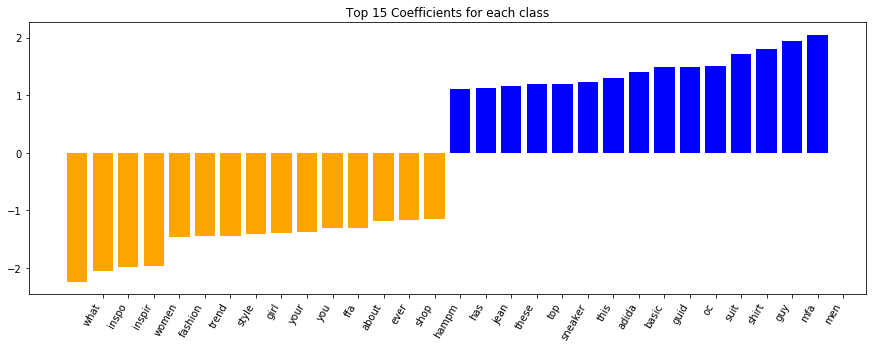

Confusion matrix, without normalization
[[187  70]
 [ 47 195]]


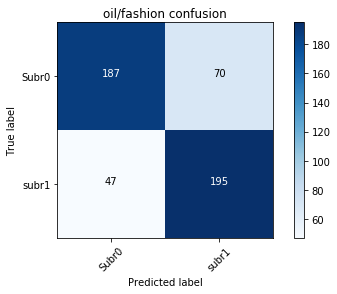

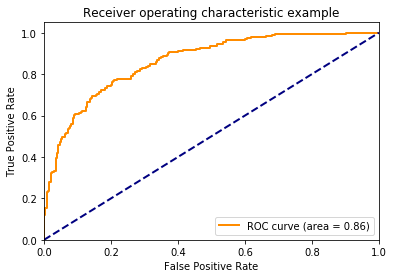

In [6]:
all_together('femalefashionadvice', 'malefashionadvice')

/r/gaming Page 0: https://www.reddit.com/r/gaming/top.json?t=all
/r/gaming Page 1: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_747h9h
/r/gaming Page 2: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_771i03
/r/gaming Page 3: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_7e3ipk
/r/gaming Page 4: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_5iq0a1
/r/gaming Page 5: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_68gbnu
/r/gaming Page 6: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_87t2pq
/r/gaming Page 7: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_70rlpl
/r/gaming Page 8: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_7ptj9n
/r/gaming Page 9: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_7aalzy
/r/gaming Page 10: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_8lafum
/r/gaming Page 11: https://www.reddit.com/r/gaming/top.json?t=all&after=t3_67a3yt
/r/gaming Page 12: https://www.reddit.com/

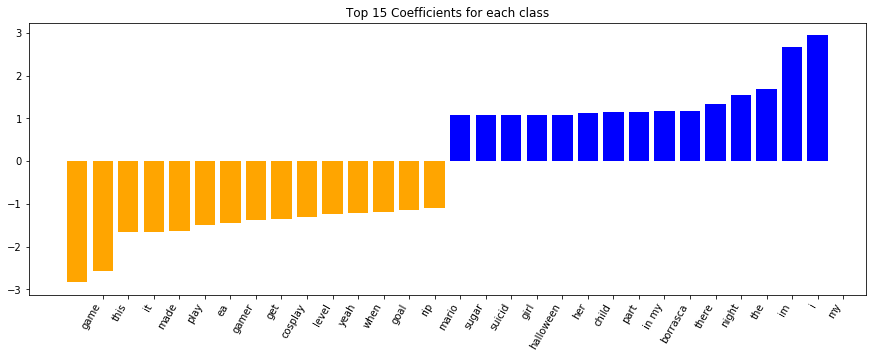

Confusion matrix, without normalization
[[207  54]
 [ 49 186]]


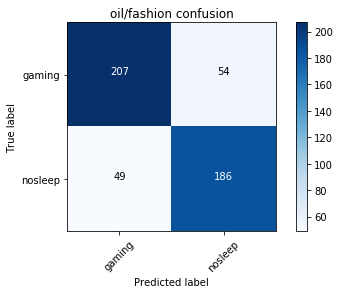

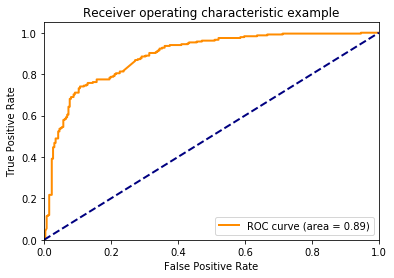

In [8]:
all_together('gaming', 'nosleep')

/r/funny Page 0: https://www.reddit.com/r/funny/top.json?t=all
/r/funny Page 1: https://www.reddit.com/r/funny/top.json?t=all&after=t3_8lbaob
/r/funny Page 2: https://www.reddit.com/r/funny/top.json?t=all&after=t3_6uiilj
/r/funny Page 3: https://www.reddit.com/r/funny/top.json?t=all&after=t3_7pt4yj
/r/funny Page 4: https://www.reddit.com/r/funny/top.json?t=all&after=t3_7qc7af
/r/funny Page 5: https://www.reddit.com/r/funny/top.json?t=all&after=t3_8ypvcs
/r/funny Page 6: https://www.reddit.com/r/funny/top.json?t=all&after=t3_88vni9
/r/funny Page 7: https://www.reddit.com/r/funny/top.json?t=all&after=t3_8v6bki
/r/funny Page 8: https://www.reddit.com/r/funny/top.json?t=all&after=t3_9b5o0h
/r/funny Page 9: https://www.reddit.com/r/funny/top.json?t=all&after=t3_7185wx
/r/funny Page 10: https://www.reddit.com/r/funny/top.json?t=all&after=t3_6v2ms5
/r/funny Page 11: https://www.reddit.com/r/funny/top.json?t=all&after=t3_7odmdl
/r/funny Page 12: https://www.reddit.com/r/funny/top.json?t=all&af

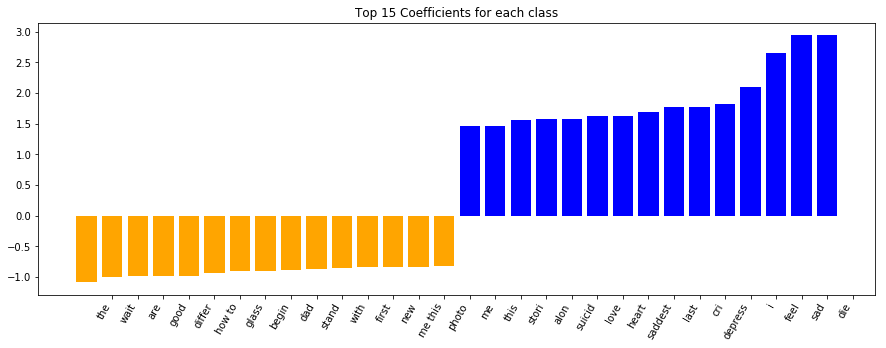

Confusion matrix, without normalization
[[181  72]
 [ 70 175]]


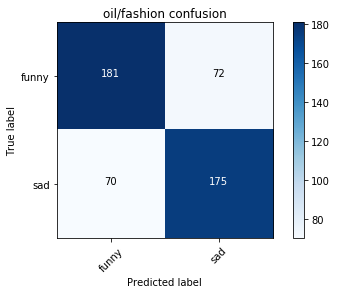

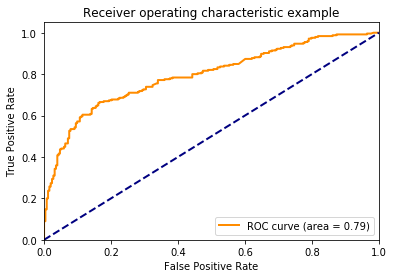

In [9]:
all_together('funny', 'sad')

# Note, below here is the work I did in developing the *all_together* subfunctions #

In [2]:
## Read the clean csvs
oil = pd.read_csv('./data_csvs/oil_clean.csv').drop('Unnamed: 0', 1)
fashion = pd.read_csv('./data_csvs/fashion_clean.csv').drop('Unnamed: 0', 1)

for df in [oil, fashion]:
    df['processed'] = df['title'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    # This will be our X and y:
    map_dict= {
        'oil': 1,
        'fashion': 0
    }
    df['subreddit'] = df['subreddit'].map(map_dict)
df = pd.concat([oil, fashion], ignore_index=True)

In [3]:
X, y = df['processed'], df['subreddit']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [77]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=9500, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
 ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [78]:
model.score(X_train, y_train)

0.9973262032085561

In [79]:
model.score(X_test, y_test)
#This is not horrible, but not great (the original two subr got a 98%)

0.9519038076152304

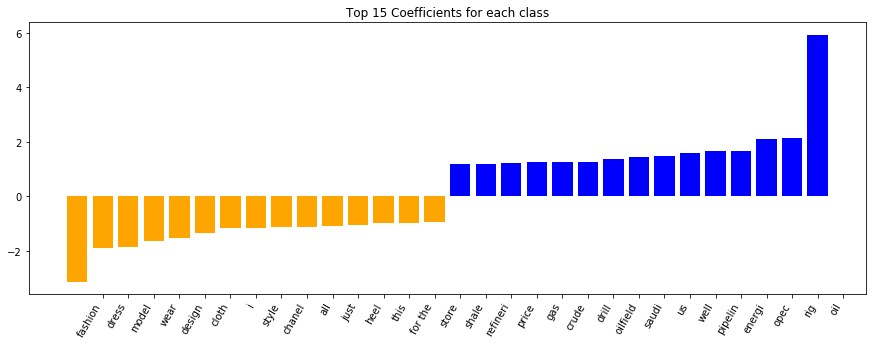

In [39]:
plot_coefficients(svc, tfidf.get_feature_names(), top_features=15)

Confusion matrix, without normalization
[[241   8]
 [ 16 234]]


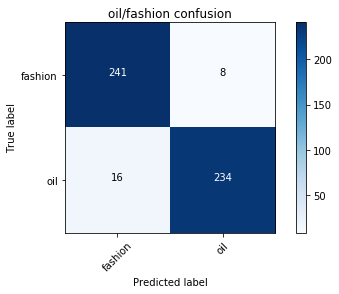

In [46]:
y_pred = model.predict(X_test);
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['0_class', '1_class'], title='oil/fashion confusion')

In [48]:
e = y_pred- y_test

In [68]:
pd.options.display.max_colwidth = 90
wrongindices= e[e !=0].index
wrongs = pd.DataFrame([X_test[wrongindices],e[wrongindices]]).T
wrongs
# wrongs['subreddit'].value_counts()
# why these wrongs? How to best explain the misclassifications?

-1    16
 1     8
Name: subreddit, dtype: int64

Training Accuracy: 0.9973262032085561
Testing Accuracy: 0.9579158316633266


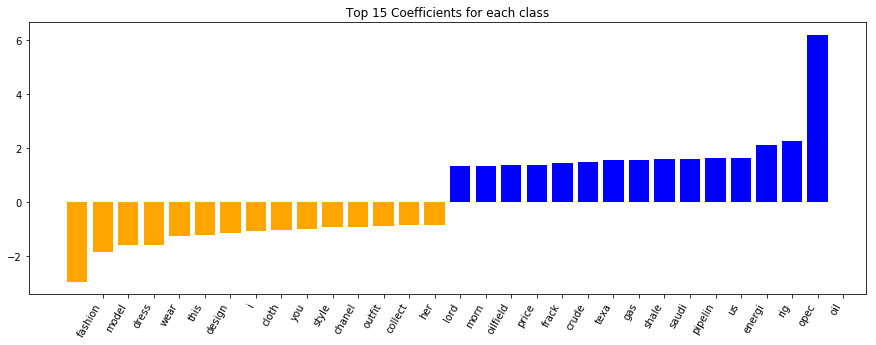

Confusion matrix, without normalization
[[234   3]
 [ 18 244]]


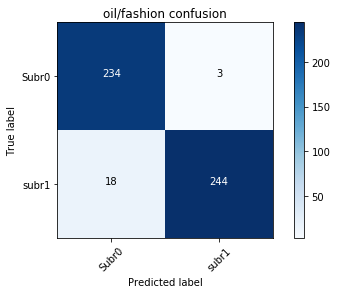

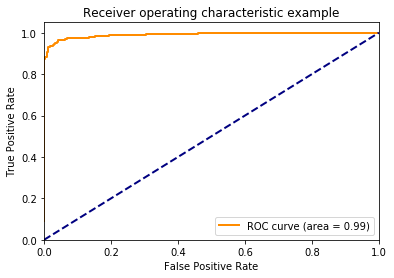

In [11]:
run_model(X, y)

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


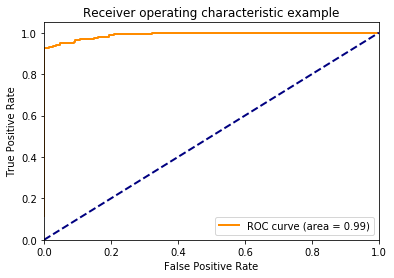

In [94]:

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# Miscillaneous things untried #
1. Feature Elimination
    - where and when to implement? Neccessary
2. Neural Networks/ other classifiers
    - How can I start approaching a multi-class model for many (all?) subreddits?
    - One V All ?


# Final Conclusions #

    1. More work needs to be done to understand how an NLP classifier can _understand_ reddit posts
    2. A more robust classifier will probably need to take into account metadata about the post including numbers/lengths, as well as selftext
    3. SVC overfits subreddits to a large extent, but why didn't it overfit askscience/futurology? Maybe because the accuracy was so high I couldn't tell. 